In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class MaskedDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu4/masked/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["masked", "unmasked"]
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu4/masked/'
train_dataset = MaskedDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = MaskedDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

19305
3058


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

class MyResnet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.backbone = resnet50()#weights=ResNet50_Weights.DEFAULT)
        del self.backbone.fc
#         self.fc1 = nn.Linear(2048, 1000)
#         self.drouput1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1000, 2)
        self.fc = nn.Linear(2048, 2)#n_classes)
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)

        x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.drouput1(x)
#         x = self.fc2(x)
        x = self.fc(x)
#         x = nn.Sigmoid()(x)
        return x

In [5]:
x = torch.randn(16, 3, 224, 224)
model = MyResnet()
# print(model)
print(model(x).shape)

torch.Size([16, 2])


In [6]:
import torch.optim as optim
from tqdm import tqdm
epochs = 40
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 


In [7]:
train_dataset = MaskedDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = MaskedDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

19305
3058


In [8]:
model = MyResnet().to(device)
if os.path.exists('last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('last.pt'))
    else:
        model.load_state_dict(torch.load('last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) 

In [9]:
best_acc = 0
best_model = MyResnet().to(device)
if os.path.exists('best.pt'):
    best_model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [10]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/40 Iter: 2414 Loss: 1.9679: 100%|██████████| 2414/2414 [02:50<00:00, 14.14it/s]


Epoch: 1/40 Test Loss: 0.1505 Test Acc: 0.9176


Epoch: 2/40 Iter: 2414 Loss: 8.3862: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 2/40 Test Loss: 0.0027 Test Acc: 0.9673


Epoch: 3/40 Iter: 2414 Loss: 0.0010: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 3/40 Test Loss: 0.0024 Test Acc: 0.9725


Epoch: 4/40 Iter: 2414 Loss: 0.0013: 100%|██████████| 2414/2414 [02:15<00:00, 17.86it/s]


Epoch: 4/40 Test Loss: 0.0007 Test Acc: 0.9774


Epoch: 5/40 Iter: 2414 Loss: 0.0300: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 5/40 Test Loss: 0.0044 Test Acc: 0.9356


Epoch: 6/40 Iter: 2414 Loss: 0.0415: 100%|██████████| 2414/2414 [02:15<00:00, 17.86it/s]


Epoch: 6/40 Test Loss: 0.0005 Test Acc: 0.9457


Epoch: 7/40 Iter: 2414 Loss: 0.0003: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 7/40 Test Loss: 0.0000 Test Acc: 0.9918


Epoch: 8/40 Iter: 2414 Loss: 0.0009: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 8/40 Test Loss: 0.0000 Test Acc: 0.9702


Epoch: 9/40 Iter: 2414 Loss: 0.0003: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 9/40 Test Loss: 0.0000 Test Acc: 0.9895


Epoch: 10/40 Iter: 2414 Loss: 2.0335: 100%|██████████| 2414/2414 [02:15<00:00, 17.88it/s]


Epoch: 10/40 Test Loss: 0.0000 Test Acc: 0.9447


Epoch: 11/40 Iter: 2414 Loss: 0.0002: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 11/40 Test Loss: 0.0001 Test Acc: 0.9869


Epoch: 12/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.83it/s]


Epoch: 12/40 Test Loss: 0.0000 Test Acc: 0.9882


Epoch: 13/40 Iter: 2414 Loss: 0.1427: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 13/40 Test Loss: 0.0000 Test Acc: 0.9853


Epoch: 14/40 Iter: 2414 Loss: 0.9676: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 14/40 Test Loss: 0.0000 Test Acc: 0.9863


Epoch: 15/40 Iter: 2414 Loss: 0.0743: 100%|██████████| 2414/2414 [02:15<00:00, 17.86it/s]


Epoch: 15/40 Test Loss: 0.0001 Test Acc: 0.9271


Epoch: 16/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 16/40 Test Loss: 0.0000 Test Acc: 0.9912


Epoch: 17/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.84it/s]


Epoch: 17/40 Test Loss: 0.0000 Test Acc: 0.9804


Epoch: 18/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 18/40 Test Loss: 0.0000 Test Acc: 0.9882


Epoch: 19/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.81it/s]


Epoch: 19/40 Test Loss: 0.0000 Test Acc: 0.9840


Epoch: 20/40 Iter: 2414 Loss: 0.0002: 100%|██████████| 2414/2414 [02:14<00:00, 17.88it/s]


Epoch: 20/40 Test Loss: 0.0000 Test Acc: 0.9853


Epoch: 21/40 Iter: 2414 Loss: 0.0031: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 21/40 Test Loss: 0.0000 Test Acc: 0.9712


Epoch: 22/40 Iter: 2414 Loss: 0.0004: 100%|██████████| 2414/2414 [02:15<00:00, 17.88it/s]


Epoch: 22/40 Test Loss: 0.0000 Test Acc: 0.9771


Epoch: 23/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 23/40 Test Loss: 0.0000 Test Acc: 0.9846


Epoch: 24/40 Iter: 2414 Loss: 0.0008: 100%|██████████| 2414/2414 [02:15<00:00, 17.88it/s]


Epoch: 24/40 Test Loss: 0.0000 Test Acc: 0.9787


Epoch: 25/40 Iter: 2414 Loss: 2.1588: 100%|██████████| 2414/2414 [02:15<00:00, 17.86it/s]


Epoch: 25/40 Test Loss: 0.0000 Test Acc: 0.9771


Epoch: 26/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 26/40 Test Loss: 0.0000 Test Acc: 0.9856


Epoch: 27/40 Iter: 2414 Loss: 0.0001: 100%|██████████| 2414/2414 [02:15<00:00, 17.88it/s]


Epoch: 27/40 Test Loss: 0.0000 Test Acc: 0.9787


Epoch: 28/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 28/40 Test Loss: 0.0000 Test Acc: 0.9899


Epoch: 29/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 29/40 Test Loss: 0.0000 Test Acc: 0.9872


Epoch: 30/40 Iter: 2414 Loss: 0.0009: 100%|██████████| 2414/2414 [02:15<00:00, 17.87it/s]


Epoch: 30/40 Test Loss: 0.0000 Test Acc: 0.9892


Epoch: 31/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:14<00:00, 17.88it/s]


Epoch: 31/40 Test Loss: 0.0000 Test Acc: 0.9830


Epoch: 32/40 Iter: 2414 Loss: 0.0004: 100%|██████████| 2414/2414 [02:14<00:00, 17.89it/s]


Epoch: 32/40 Test Loss: 0.0000 Test Acc: 0.9820


Epoch: 33/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:14<00:00, 17.91it/s]


Epoch: 33/40 Test Loss: 0.0000 Test Acc: 0.9892


Epoch: 34/40 Iter: 2414 Loss: 0.0040: 100%|██████████| 2414/2414 [02:15<00:00, 17.84it/s]


Epoch: 34/40 Test Loss: 0.0001 Test Acc: 0.9706


Epoch: 35/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.84it/s]


Epoch: 35/40 Test Loss: 0.0000 Test Acc: 0.9823


Epoch: 36/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 36/40 Test Loss: 0.0000 Test Acc: 0.9908


Epoch: 37/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.88it/s]


Epoch: 37/40 Test Loss: 0.0000 Test Acc: 0.9794


Epoch: 38/40 Iter: 2414 Loss: 0.0000: 100%|██████████| 2414/2414 [02:15<00:00, 17.84it/s]


Epoch: 38/40 Test Loss: 0.0000 Test Acc: 0.9820


Epoch: 39/40 Iter: 2414 Loss: 0.0016: 100%|██████████| 2414/2414 [02:15<00:00, 17.81it/s]


Epoch: 39/40 Test Loss: 0.0000 Test Acc: 0.9797


Epoch: 40/40 Iter: 2414 Loss: 1.0021: 100%|██████████| 2414/2414 [02:15<00:00, 17.85it/s]


Epoch: 40/40 Test Loss: 0.0012 Test Acc: 0.9382


In [11]:
test_model = MyResnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyResnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [12]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["masked", "unmasked"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[912, 585, 902, 1293, 2967, 2895, 1250, 608]
torch.Size([8, 3, 224, 224])
[1, 1, 1, 1, 1, 1, 1, 1]
tensor([1, 1, 1, 1, 1, 1, 1, 1])


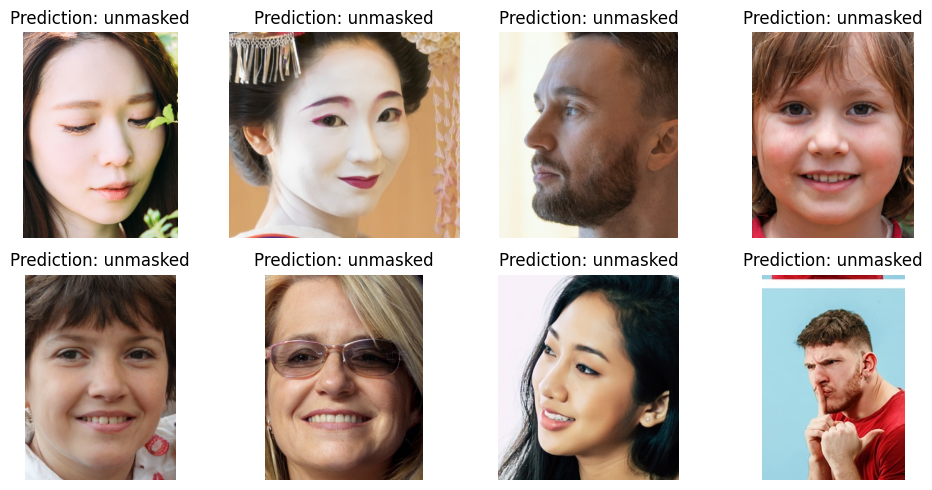

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()